<a href="https://colab.research.google.com/github/garylau1/model_training/blob/main/generative_text_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
from torch import nn
import urllib.request
import tarfile
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
import scipy.io
from PIL import Image

In [2]:
image_dir=os.path.join(os.getcwd(),"jpg")
data_dir=os.path.join(os.getcwd(),"data.tgz")

In [3]:
import urllib.request
urllib.request.urlretrieve("https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz", data_dir)

('/content/data.tgz', <http.client.HTTPMessage at 0x7f402ff5fa50>)

In [4]:
urllib.request.urlretrieve("https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat", "imagelabels.mat")


('imagelabels.mat', <http.client.HTTPMessage at 0x7f40305004d0>)

In [19]:
with tarfile.open("/content/data.tgz", "r:gz") as tar:
    #tar.list()
    tar.extractall(path=os.getcwd())

transforms_=transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

transforms_

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [20]:
class flower101(Dataset):
  def __init__(self,image_dir,label_file,transform_):
    self.image_dir=image_dir
    self.name_list=[f for f in os.listdir(self.image_dir) if f.endswith(".jpg")]
    self.transform_=transform_

    self.name_list.sort()
    self.label=scipy.io.loadmat(label_file)["labels"].flatten()-1
  def __len__(self):
    return len(self.name_list)

  def __getitem__(self,inx):
    name1=self.name_list[inx]
    image_path=os.path.join(self.image_dir,name1)
    target_label=self.label[inx]
    target_iamge=Image.open(image_path).convert("RGB")

    return self.transform_(target_iamge),torch.tensor(target_label,dtype=torch.long)



In [21]:
dataset=flower101(image_dir,"/content/imagelabels.mat",transforms_)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


But in a first layer we didn't use it because uh, the, the first layer of the discriminator processes

a raw input data, which can be noisy.

And applying BatchNorm directly to this raw input could potentially normalize away useful features that

are essential for distinguishing real image from generated ones.

1. Smooth Transition of Features:
Each layer of the generator refines the features from the previous layer. Early layers handle abstract, high-level patterns (like shapes or textures), while later layers deal with finer details (like edges or colors).
Gradually reducing the channels ensures a smooth transition from abstract features to specific, meaningful patterns. A sudden reduction would discard too much information and likely result in poor-quality outputs.

Preserving Rich Information:
High-dimensional features (many channels) in early layers carry a wide variety of information needed to generate realistic details.
If the channels were suddenly reduced, the generator might lose important information required to reconstruct the final image.


Spatially, you focus narrows or dimension decrease, but you consider more aspects, which is the channel

increase.

So this was just an example.

combines and refines these features, reducing redundancy and focusing on essential
details needed

from the image.



In [22]:
num_classes = 102
class generator(nn.Module):
  def __init__(self,latent_dim,label_dim):
    super(generator,self).__init__()
    self.embedding=nn.Embedding(num_classes, label_dim)
    self.Sequential=nn.Sequential(nn.ConvTranspose2d(latent_dim+label_dim,512,4,1,0,bias=False),nn.BatchNorm2d(512),nn.ReLU(),
                                  nn.ConvTranspose2d(512,256,4,2,1,bias=False),nn.BatchNorm2d(256),nn.ReLU(),
                                  nn.ConvTranspose2d(256,128,4,2,1,bias=False),nn.BatchNorm2d(128),nn.ReLU(),
                                  nn.ConvTranspose2d(128,64,4,2,1,bias=False),nn.BatchNorm2d(64),nn.ReLU(),
                                  nn.ConvTranspose2d(64,3,4,2,1,bias=False),
                                  nn.Tanh())

  def forward(self,noise,label):
    label_emd=self.embedding(label).unsqueeze(2).unsqueeze(3)   #label=(batch,embeddinglayer,1,1)
    return self.Sequential(torch.cat((noise,label_emd),1))  #label has 4d and noise has 4d as well noise(batch,latent,1,1)


class discriminator(nn.Module):
  def __init__(self,label_dim):
    super(discriminator,self).__init__()   #latent time is for nosie vector #extra information for label
    self.embedding=nn.Embedding(num_classes, label_dim)
    self.Sequential=nn.Sequential(nn.Conv2d(3+label_dim,64,4,2,1,bias=False),nn.LeakyReLU(0.2,inplace=True),  #not batch-normalizeise useful feature
                                  nn.Conv2d(64,128,4,2,1,bias=False),nn.BatchNorm2d(128),nn.LeakyReLU(0.2,inplace=True),
                                  nn.Conv2d(128,256,4,2,1,bias=False),nn.BatchNorm2d(256),nn.LeakyReLU(0.2,inplace=True),
                                  nn.Conv2d(256,512,4,2,1,bias=False),nn.BatchNorm2d(512),nn.LeakyReLU(0.2,inplace=True),
                                  nn.Conv2d(512,1,4,1,0,bias=False),
                                  nn.Sigmoid())
  def forward(self,input,label):
    label_emd=self.embedding(label).unsqueeze(2).unsqueeze(3)
    label_expand=label_emd.expand(label_emd.shape[0],label_emd.shape[1],input.size(2),input.size(3))


    return self.Sequential(torch.cat((input,label_expand),1)).view(-1,1)
    #img=(64,3,64,64) + ( 64,label_dim ,64,64)





In [23]:
latent_dim=100
label_dim=50
num_classes=102
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G=generator(latent_dim,label_dim).to(device)
D=discriminator(label_dim).to(device)

G_optim=torch.optim.Adam(G.parameters(),lr=0.0002)
D_optim=torch.optim.Adam(D.parameters(),lr=0.0002)
loss_fn=nn.BCELoss()


In [24]:
for epoch in range(100):
  for i ,(input,label) in enumerate(dataloader):
    batch_size=input.size(0)
    noise_vector=torch.randn(batch_size,latent_dim,1,1,device=device)
    label_input=label.to(device)
    input=input.to(device)
    #generator for D
    fake_image=G(noise_vector,label_input)

    real_output=D(input,label_input)

    fake_output=D(fake_image.detach(),label_input)

    real_label=torch.ones(batch_size,1,device=device)
    fake_label=torch.zeros(batch_size,1,device=device)

    D_loss_real=loss_fn(real_output,real_label)
    D_loss_fake=loss_fn(fake_output,fake_label)

    D_loss=(D_loss_real+D_loss_fake)*0.5

    D_optim.zero_grad()
    D_loss.backward()
    D_optim.step()
  ####################################################
    G_optim.zero_grad()
    noise_vector=torch.randn(batch_size,latent_dim,1,1,device=device)
    fake_image=G(noise_vector,label_input)


    fake_output=D(fake_image,label_input)

    G_loss_fake=loss_fn(fake_output,real_label)

    G_loss=G_loss_fake


    G_loss.backward()
    G_optim.step()
  print (f"We are in {epoch+1} |lost_G : {G_loss.item()} | lost_D : {D_loss.item()}")


We are in 1 |lost_G : 3.50449275970459 | lost_D : 0.36042240262031555
We are in 2 |lost_G : 4.401219844818115 | lost_D : 0.07404661178588867
We are in 3 |lost_G : 6.464813709259033 | lost_D : 0.10056091845035553
We are in 4 |lost_G : 6.534204483032227 | lost_D : 0.022053971886634827
We are in 5 |lost_G : 6.209323406219482 | lost_D : 0.11866077780723572
We are in 6 |lost_G : 7.632361888885498 | lost_D : 0.023633962497115135
We are in 7 |lost_G : 4.659491062164307 | lost_D : 0.16376987099647522
We are in 8 |lost_G : 3.048154592514038 | lost_D : 0.07136330008506775
We are in 9 |lost_G : 1.6829785108566284 | lost_D : 0.14957664906978607
We are in 10 |lost_G : 5.988478183746338 | lost_D : 0.19450736045837402
We are in 11 |lost_G : 6.707306385040283 | lost_D : 0.1356380432844162
We are in 12 |lost_G : 2.4507386684417725 | lost_D : 0.2411803901195526
We are in 13 |lost_G : 3.1665937900543213 | lost_D : 0.26796770095825195
We are in 14 |lost_G : 2.7393922805786133 | lost_D : 0.1793912649154663

KeyboardInterrupt: 

In [25]:
def create_image(label_input,G=G):
  G.eval()
  noise_vector=torch.randn(1,latent_dim,1,1,device=device)
  label_input=torch.tensor([label_input]).to(torch.int64).to(device)
  with torch.no_grad():
      fake_image=G(noise_vector,label_input)
      fake_image=fake_image.detach().cpu().squeeze().permute(1,2,0).numpy()
      fake_image=(fake_image+1)/2

  import numpy as np
  import matplotlib.pyplot as plt
  plt.imshow(fake_image)
  plt.axis("off")
  plt.show()




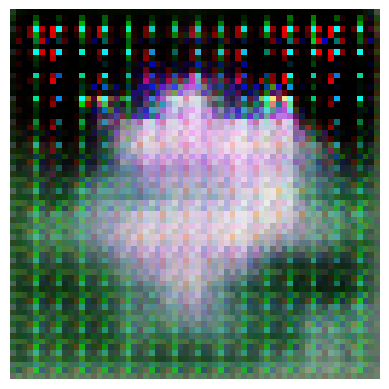

In [34]:
import random
create_image(random.randint(0, 101),G=G)